# Region Class Definition

## Setup

### Imports

In [1]:
from typing import List

# Shared Packages
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon
import matplotlib.pyplot as plt

# Local functions and classes
from types_and_classes import *
from utilities import *
from debug_tools import *
from structure_slice import *
from structure_set import *
#from metrics import *
from relations import *

### Global Settings

In [2]:
PRECISION = 2

In [3]:
%matplotlib inline

## Need to do boundary checks by region not by structure


- Make a Region class with the following attributes:
    - ROI: ROI_Type, 
    - slice: SliceIndexType, 
    - is_hole: bool,
    - is_boundary: bool,
    - region_labels: List[str], 
    - polygon: ContourType
- Step through all structures and separate each slice into individual polygons 
    and holes (Regions)
- Apply region labels, based on overlapping polygons.
  - Set unique labels for each region on the first slice: 'a', 'b' ...
  - find overlapping polygons on the next slice and give them the same 
      region labels.
  - A polygon can be in multiple regions.
- If a polygon in the current region is not matched to a polygon in the next 
    region, it is a boundary polygon.
- If a polygon in the next region is not matched with a polygon in the current 
    region, it is a boundary polygon. Assign it to a new region
- Store as a list of dictionaries with keys: ROI, slice, is_hole, polygon
- convert to a DataFrame and sort on ROI and slice


`object.relate_pattern(other, pattern)`
> Returns True if the *DE-9IM* string code for the relationship between the geometries satisfies the pattern, otherwise False.

- The `relate_pattern()` compares the *DE-9IM* code string for two geometries against a specified pattern. If the string matches the pattern then True is returned, otherwise False. 
- The pattern specified can be an exact match (`0`, `1` or `2`), a boolean match (`T` or `F`), or a wildcard (`*`). 
- For example, the pattern for the within predicate is `'T*****FF*'`.

```python
point = Point(0.5, 0.5)
square = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
square.relate_pattern(point, 'T*****FF*')
```

> True

`point.within(square)`

> True

Note that the order or the geometries is significant, as demonstrated below. In this example the square contains the point, but the point does not contain the square.

`point.relate(square)`

> '0FFFFF212'

`square.relate(point)`

> '0F2FF1FF2'

# 1st test

In [4]:
def simple_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1,
                                  offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder within primary
    contained_cylinder = make_vertical_cylinder(roi_num=2, radius=3, length=0.5,
                                             offset_x=0, offset_z=-0.2,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, contained_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [5]:
slice_table = simple_cylinders()
regions = generate_region_graph(slice_table)
selected_roi = [1, 2]
find_relations(slice_table, regions, selected_roi).identify_relation()

In [16]:
def dual_embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole, middle_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [17]:
slice_table = dual_embedded_cylinder()


In [20]:
def generate_region_graph(slice_table: pd.DataFrame) -> RegionGraph:
    '''Generate a region graph from a slice table.

    Args:
        slice_table (pd.DataFrame): A table of StructureSlice data with
            SliceIndex as the index.

    Returns:
        nx.Graph: A graph representing the regions in the slice table.
    '''
    def create_edges(graph: nx.Graph) -> None:
        '''Create edges between nodes in the graph based on specified criteria.

        Args:
            graph (nx.Graph): The graph containing the nodes.
        '''
        for node1, node2 in combinations(graph.nodes(data=True), 2):
            roi1, slice_index1, _ = node1[0]
            roi2, slice_index2, _ = node2[0]
            if roi1 != roi2:
                continue
            if not node1[1]['slice_neighbours'].is_neighbour(slice_index2):
                continue
            if node1[1]['is_hole'] != node2[1]['is_hole']:
                continue
            if node1[1]['polygon'].intersects(node2[1]['polygon']):
                weight = abs(slice_index1 - slice_index2)
                graph.add_edge(node1[0], node2[0], weight=weight)

    graph = nx.Graph()
    for _, row in slice_table.iterrows():
        for structure_slice in row.dropna():
            structure_slice.extract_regions(graph)
    create_edges(graph)
    return graph

In [21]:
regions = generate_region_graph(slice_table)


In [24]:
slice_table

ROI Num,0,1,2
Slice Index,,,
-0.5,<structure_slice.StructureSlice object at 0x00...,NaN,NaN
-0.4,<structure_slice.StructureSlice object at 0x00...,NaN,NaN
-0.3,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,NaN
-0.2,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
-0.1,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.0,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.1,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.2,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.3,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,NaN


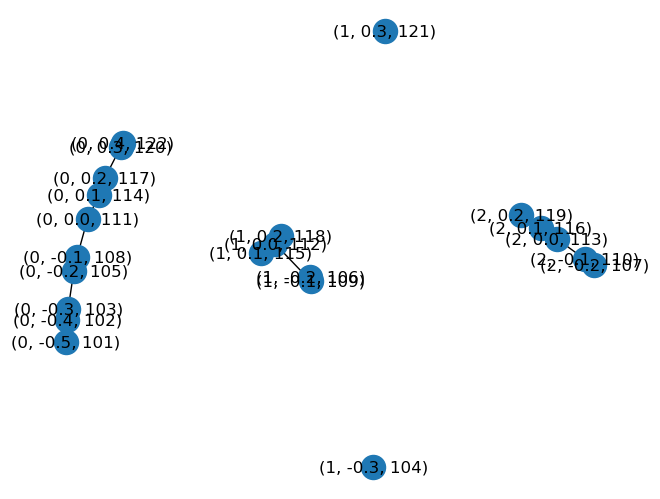

In [23]:
pos = nx.multipartite_layout(regions, subset_key='roi')
pos = nx.forceatlas2_layout(regions, pos=pos)
nx.draw(regions, pos=pos, with_labels=True)

In [ ]:
generate_interpolated_boundaries(regions)


In [ ]:
selected_roi = [1, 2]
find_relations(slice_table, regions, selected_roi).identify_relation()

**Note:** The Last slice of Region 0 (Body) is not registering as a boundary
- Modify the code to include the last slice as a boundary